# Performance computing in python

## Some background - CPython

CPython is the reference implementation of the Python programming language.

### Key Points

1. **Written in the `C` programming language**: Hence the name "CPython"
2. **Most widely used**: It's the standard Python implementation
3. **Compiler and Interpreter**: 
   - Compiles Python code to bytecode
   - Interprets the bytecode
4. **Comprehensive**: Includes the Python standard library and core language features
5. **Open-source**: Serves as a blueprint for other Python implementations

CPython is the foundation upon which most Python development is built.

### CPython: Pros and Cons

#### Pros

1. Large ecosystem
   - Most Python libraries and frameworks are built for CPython
1. Stability and reliability
   - Well-tested and mature
1. Regular updates
   - Frequent bug fixes and performance improvements
1. C extensions support
   - Allows for performance-critical parts to be written in C
1. Memory management
   - Built-in garbage collection

#### Cons

1. Global Interpreter Lock (GIL)
   - Limits true multi-threading for CPU-bound tasks
1. **Performance**
   - Generally slower than compiled languages for certain tasks
1. Memory usage
   - Can be higher compared to some other implementations
1. Startup time
   - Can be slow, especially for small scripts
1. Platform dependence
   - Binaries are not cross-platform

So, if we want CPython but faster, what can we do?

## Cython

[Cython](http://docs.cython.org/src/userguide/numpy_tutorial.html#cython-at-a-glance) is a compiler that converts Python-like code to C code, but it's not a direct Python-to-C translator. Instead, it:

- Compiles to native machine code while still using the Python runtime environment
- Adds syntax for embedding faster C-like code

### Key Consequences

1. **Speed Improvements**
   - Minimal for typical numerical programs
   - Significant for for-loop-style programs with added type information

2. **Easier C Integration**
   - Simplifies wrapping C libraries
   - Allows calling C code as easily as Python code

### Limitations

- Not all Python constructs are supported (e.g., inner functions, generator functions)
- Goal is to eventually support all Python code

## Hello world!

Let's start with a simple *Hello World!* to check that everything is working.

We load the `Cython` magic that will allow us to quickly use Cython inside the notebook. The magic is installed with the `cython` package (`conda install cython` or `pip install cython`). The Cython requires that a C compiler is installed and can be found, and on Windows that may be tricky, here are some resources:

- [Install Cython on Windows](https://github.com/cython/cython/wiki/InstallingOnWindows)
- [Install C compiler on Windows](https://github.com/cython/cython/wiki/CythonExtensionsOnWindows)
- [Compiling Python extensions on Windows](https://blog.ionelmc.ro/2014/12/21/compiling-python-extensions-on-windows/)

On Linux/OSX you probably already have a compiler, check with `!gcc --version`. If `gcc` is not found, install it:

- On [Ubuntu](https://help.ubuntu.com/community/InstallingCompilers) you should run `sudo apt-get install build-essential`.
- On CentOS you just need to install development tools: `sudo yum group install "Development Tools"`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os

import Cython
print("Cython", Cython.__version__)

%load_ext Cython

Cython 3.0.10


In [2]:
%%cython 
print("Hello World!")

Hello World!


## First Cython example

Let's see a quick example of what Cython can do for us. 

Consider the following Python [function that returns the first k prime numbers](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html) (but not more than 1000):

In [3]:
def find_k_primes(k):
    primes = [None] * 1000 # pre-allocate so not to use append
    n_primes = 0  # the current number of numbers in primes
    candidate = 2
    while n_primes < min(k, 1000):
        # is candidate prime?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return primes[:n_primes]

In [4]:
assert find_k_primes(10) == [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Here is the Cython version of this function; the only addition here is that we use `cdef` to define the types of all local variabes. This `cdef` statement is used to define **local C variables**. We also add `int` in the arguments list to define the type of `k`; this means that any object passed will be **converted to a C integer**.

In [5]:
%%cython
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0  # the current number of elements in primes
    candidate = 2
    while n_primes < min(k, 1000):
        # is candidate prime?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    # convert primes from a cython type to a python list
    return [p for p in primes[:n_primes]] 

In [6]:
find_k_primes(100) == cfind_k_primes(100)

True

In [19]:
n = 1000
%timeit find_k_primes(n)
%timeit cfind_k_primes(n)

30.8 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.44 ms ± 6.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Note that in the inner loop, only variables with type definitions, and thus C objects, are reffered to; therefore, the loop is translated to a C loop, and runs very fast.

### Example - integration

This is from Robert Bradshaw [SciPy 2008 slides](http://wiki.sagemath.org/scipy08?action=AttachFile&do=get&target=scipy-cython.tgz).

We will write a simple integration code to integrate $f(x) = x^3 - 3x$:

In [20]:
def f(x):
    return x**3 - 3 * x

def integrate_f(a , b , N):
    s = 0
    dx = (b - a )/ N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

integrate_f(0, 1, 100000)

-1.249989999975006

In [21]:
%timeit integrate_f(0, 1, 100000)

21.6 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now, the same with Cython. Note that when we define a function with `cdef` we can set a return value but we can only c
all it from within Cython. When we define a function with `def` we can import it and call it from Python.

Note that we change `x**3` to `x * x * x`.

In [22]:
%%cython
cdef double g(double x):
    return x * x * x - 3* x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a )/ N
    cdef int i
    for i in range(N):
        s += g( a + i * dx )
    return s * dx

In [23]:
integrate_g(0, 1, 100000)

-1.249989999975006

In [24]:
%timeit integrate_g(0, 1, 100000)

147 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Now let's integrate 
$$
\int_a^b{\frac{\sin{x}}{x}}
$$

Without Cython, we should use either `math.sin` or `numpy.sin`:

In [25]:
def f(x):
    return np.sin(x) / x

integrate_f(1, 2, 100000)

0.6593318405457452

With Cython, we can import some C functions using an `extern` block:

In [26]:
%%cython
cdef extern from "math.h":
    double sin(double)
    double cos(double)

cdef double g(double x):
    return sin(x)/x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a) /  N
    cdef int i
    for i in range(N):
        s += g(a + i * dx)
    return s * dx

In [ ]:
integrate_g(1, 2, 100000)

In [27]:
%timeit integrate_f(1, 3, 100000)
%timeit integrate_g(1, 3, 100000)

88.4 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.01 ms ± 53.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Cython + NumPy

Cython works well with NumPy.

Let's loop over a NumPy array:

In [28]:
def summ(x):
    s = 0
    for i in range(x.shape[0]):
        s += x[i]
    return s

In [30]:
%%cython
cimport numpy as np

def csumm(long[:] x): # input type is a buffer
    cdef int i = 0
    cdef long s = 0
    cdef Py_ssize_t size = x.shape[0]
    for i in range(size):
        s += x[i]
    return s

Content of stderr:
In file included from /home/pupkolab/envs/pyCourse/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/pupkolab/envs/pyCourse/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/pupkolab/envs/pyCourse/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/pupkolab/.cache/ipython/cython/_cython_magic_227319ed79e184aab9d0452b7ee36871b2a2d123.c:1250:
/home/pupkolab/envs/pyCourse/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [31]:
x = np.random.randint(0, 9, 100000)
summ(x), csumm(x)

(402159, 402159)

In [32]:
%timeit summ(x)
%timeit csumm(x)

10.9 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.6 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Note that if you would type `s` and `arr` as made of `int` you would get an error because Python's `int` is a C `long`... But you would get a `ValueError`, not a segmentation fault or anything like that. Here's an example:

In [33]:
y = np.array([0.1, 0.2, 0.3])
csumm(y)

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'

### Example - Mandelbrot fractal

In [34]:
import numpy as np

def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [71]:
%%cython
def cmandelbrot(long[:,:] m,
                int size,
                int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100: # note - no use of np.abs
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [88]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int64)

In [52]:
%timeit mandelbrot(m, size, iterations)
%timeit cmandelbrot(m, size, iterations)

929 ms ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

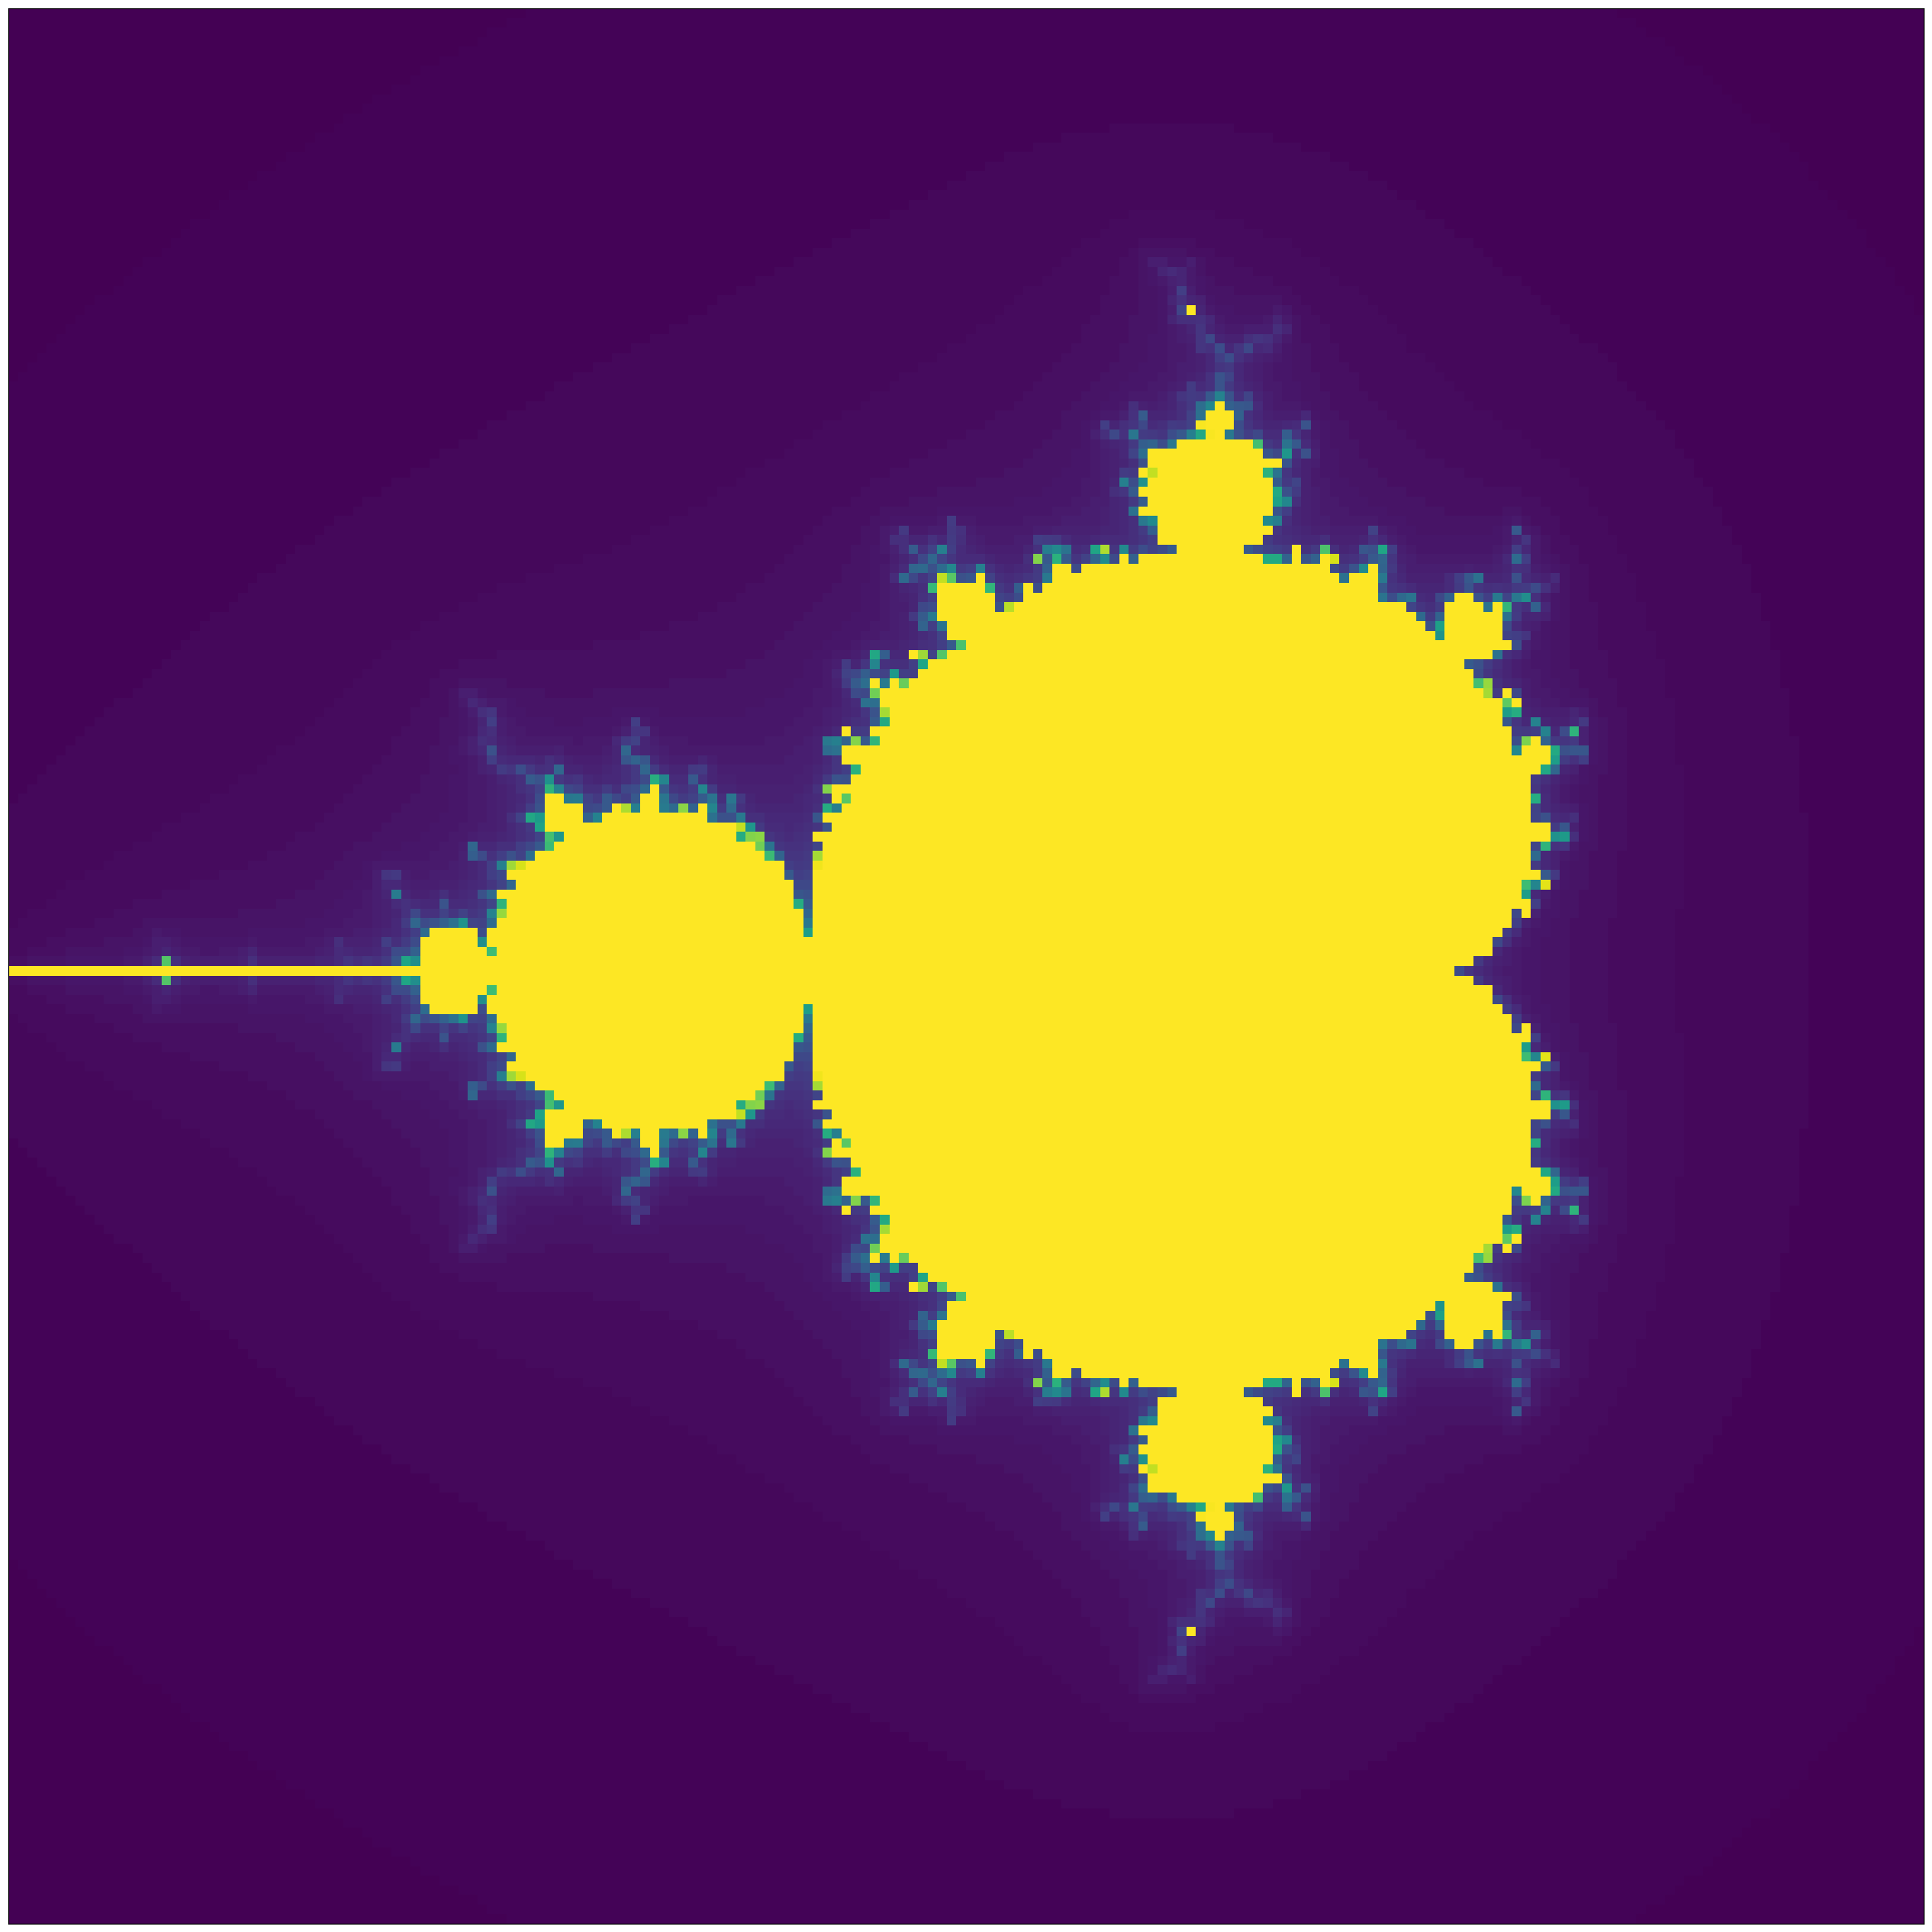

In [90]:
mandelbrot(m, size, iterations)
plt.figure(figsize=(30, 30))
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

## Numba

[Numba](http://numba.pydata.org) is a just-in-time (JIT) compiler for Python, focusing on numerical and scientific computing.

### Key Features

1. **Performance**
   - Compiles Python code to native machine instructions
   - Achieves performance similar to C, C++, and Fortran

2. **Ease of Use**
   - Works with Python code directly
   - Requires minimal annotations

3. **JIT Compilation**
   - Combines speed of compiled code with flexibility of interpretation
   - Incurs some overhead for compilation
   - More on [JIT compilation](https://en.wikipedia.org/wiki/Just-in-time_compilation)

4. **Multithreading Support**
   - Allows release of the Global Interpreter Lock (GIL)
   - Enables true multithreading for CPU-bound tasks

5. **Automatic Parallelization**
   - Can parallelize code automatically in some cases

Numba is particularly effective for array-oriented and math-heavy Python code, offering significant speed improvements without changing languages or Python interpreters.

In [91]:
import numba
print('Numba', numba.__version__)

Numba 0.60.0


In [92]:
@numba.jit()
def numandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
numandelbrot(m, size, iterations); # run once for jit to work

In [94]:
size = 1000
iterations = 1000
m = np.zeros((size, size), dtype=np.int64)

# %timeit mandelbrot(m, size, iterations) # too slow
%timeit cmandelbrot(m, size, iterations)
%timeit numandelbrot(m, size, iterations)

616 ms ± 7.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.33 s ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Exercise - Numba

Consider the following NumPy function which calculates the mean squared error of two arrays:

In [95]:
n = 100000
x = np.random.random(n)
y = np.random.random(n)

In [96]:
def mse_np(x, y):
    return ((x - y)**2).mean()

mse_np(x, y)

0.16571812243221626

In [ ]:
def mse_py(x, y):
    pass

def mse_nm(x, y):
    pass

In [ ]:
%timeit mse_py(x, y)
%timeit mse_np(x, y)
%timeit mse_nm(x, y)

### Numba automatic parallelization

Numba uses Intel's MKL to automate parallelization of for loops with multiple threads.

Consider the function for calculation of MSE:

In [97]:
n = 1000000
x = np.random.random(n)
y = np.random.random(n)

In [98]:
@numba.jit
def mse_nm(x, y):
    mse = 0
    n = len(y)
    for i in range(n):
        mse += (x[i] - y[i])**2
    mse /= n
    return mse

mse_nm(x, y)

0.1666423287091223

We can parallelize it by adding the `parallel=True` directive (which requires that we can set `nopython=True` without getting an error) and using `numba.prange` instead of `range`:

In [99]:
@numba.jit(parallel=True)
def mse_par(x, y):
    mse = 0
    n = len(y)
    for i in numba.prange(n):
        mse += (x[i] - y[i])**2
    mse /= n
    return mse

mse_par(x, y)

0.16664232870913168

In [101]:
%timeit mse_nm(x, y)
%timeit mse_par(x, y)

1.28 ms ± 13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
592 µs ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Noteworthy alternatives

- Writing Python extensions in a low level language, e.g. C, C++, Rust.
- Pypy: A Python implementation with built in JIT.
- Mojo programming language - very new, not actually Python but looks like it.
